## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [59]:
# 從網路即時下載CIFAR10⼩圖像，數據集涵蓋50,000張32x32彩⾊色訓練圖像及10,000張測試圖像，並且標註超過10個類別
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 查詢檔案維度資訊
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [0]:
# 資料前處理
def preproc_x(x):
    x = x / 255.
    return x

def preproc_y(y, num_classes=10):
    from keras.utils import to_categorical

    y = to_categorical(y, num_classes)
    return y    

In [61]:
# 將資料從圖形 (RGB) 轉為向量 (Single Vector) 並進行標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")


# 將目標轉為 one-hot encoding
y_train = preproc_y(y_train, num_classes=10)
y_test = preproc_y(y_test, num_classes=10)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 32, 32, 3)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_train: (50000, 10)
Shape of y_test: (10000, 10)


In [0]:
from keras.regularizers import l1_l2
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import layers, models

def build_model(input_shape, output_units=10, num_neurons=[32, 64], l1_ratio=0, l2_ratio=0, drop_ratio=0.25):
    model = models.Sequential()
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            # 第一層
            model.add(layers.Conv2D(n_units, (3, 3), activation='relu', input_shape=(input_shape), kernel_regularizer=l1_l2(l1_ratio, l2_ratio)))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(BatchNormalization())
            model.add(Dropout(drop_ratio))
        else:
            # 後續幾層
            model.add(layers.Conv2D(n_units, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1_ratio, l2_ratio)))
            model.add(layers.MaxPooling2D((2, 2)))
            model.add(BatchNormalization())
            model.add(Dropout(drop_ratio))

    # 最後一層
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(output_units, activation='softmax'))
    return model

In [0]:
# 超參數設定
learning_rate = 1e-3
epochs = 50
batch_size = 512
l1_reg = 0
l2_reg = 0.0001
drp_ratio = 0.25

In [64]:
import keras
keras.backend.clear_session()

model = build_model(input_shape=x_train.shape[1:], output_units=10, num_neurons=[32, 64, 64], l1_ratio=l1_reg, l2_ratio=l2_reg, drop_ratio=drp_ratio)
print(model.summary())

model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_test, y_test), 
                    shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 64)         

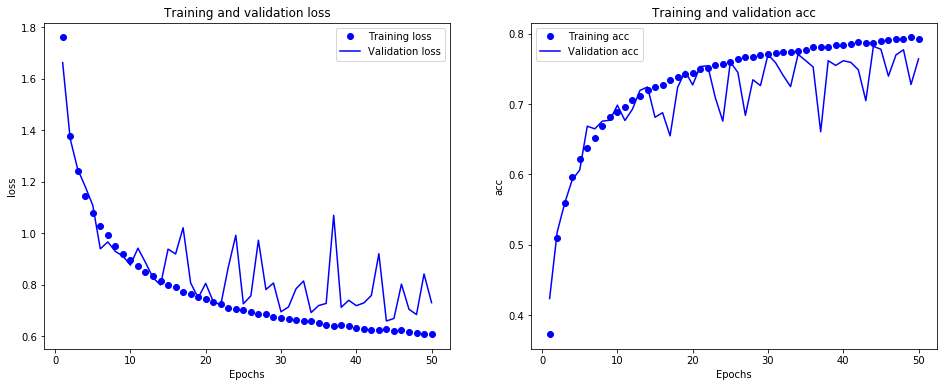

In [65]:
# 以視覺畫方式檢視訓練過程
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(history.history['loss']) + 1)

rows, cols = 1, 2
figure, ax = plt.subplots(rows, cols, figsize=(16,6))
for i, score in enumerate(['loss', 'acc']):
    plt.subplot(1, 2, i+1)
    plt.plot(epochs, history.history[score], 'bo', label='Training '+score)
    plt.plot(epochs, history.history['val_'+score], 'b', label='Validation '+score)
    plt.title('Training and validation '+score)
    plt.xlabel('Epochs')
    plt.ylabel(score)
    plt.legend()